# Import The Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [ ]:
# Import the time series data from CSV file
df=pd.read_csv('/content/UNVR.JK (3).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-22,9840.0,9900.0,9760.0,9760.0,8073.905762,8018000
1,2017-06-23,9760.0,9760.0,9760.0,9760.0,8073.905762,0
2,2017-06-26,9760.0,9760.0,9760.0,9760.0,8073.905762,0
3,2017-06-27,9760.0,9760.0,9760.0,9760.0,8073.905762,0
4,2017-06-28,9760.0,9760.0,9760.0,9760.0,8073.905762,0
...,...,...,...,...,...,...,...
1730,2024-06-13,3060.0,3120.0,3060.0,3060.0,3060.000000,11469600
1731,2024-06-14,3090.0,3210.0,3070.0,3200.0,3200.000000,31693600
1732,2024-06-19,3200.0,3200.0,3060.0,3070.0,3070.000000,26712400
1733,2024-06-20,3090.0,3100.0,2950.0,3040.0,3040.000000,15901600


In [ ]:
#Select the Data & Price Columns and copy them into a new data frame
Data = df[['Date', 'Close']].copy()
#Set the data column to the standard pandas format
Data['Date'] = pd.to_datetime(df['Date'])
#Set the Date column as index
Data.set_index('Date', inplace=True)
# Rename the price column "Close" to "Saham Unilever"
Data.rename(columns={'Close': 'Saham Unilever'}, inplace=True)
Data.head()

,Saham Unilever
Date,
2017-06-22,9760.0
2017-06-23,9760.0
2017-06-26,9760.0
2017-06-27,9760.0
2017-06-28,9760.0


<Axes: title={'center': 'Saham Unilever'}, xlabel='Date'>

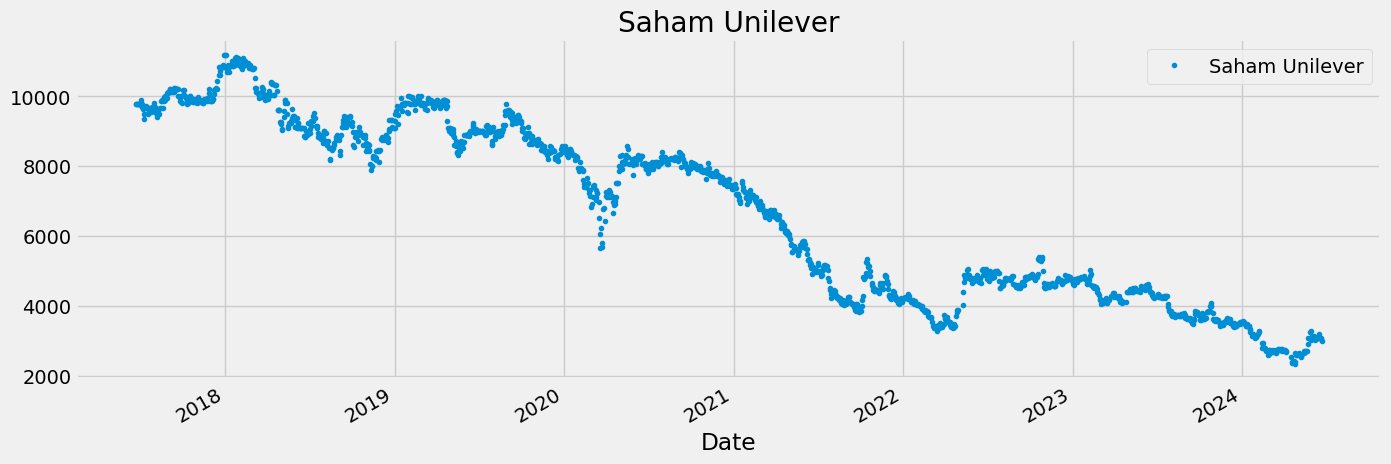

In [ ]:
# Visualize the time series data on a plot
Data.plot(style='.', figsize=(15,5), title='Saham Unilever')

In [ ]:
# Calculate the 80% split index
split_index = int(len(Data) * 0.8)

# Split the data
train = Data.iloc[:split_index].copy()
test = Data.iloc[split_index:].copy()

<Axes: title={'center': 'Saham Unilever'}, xlabel='Date'>

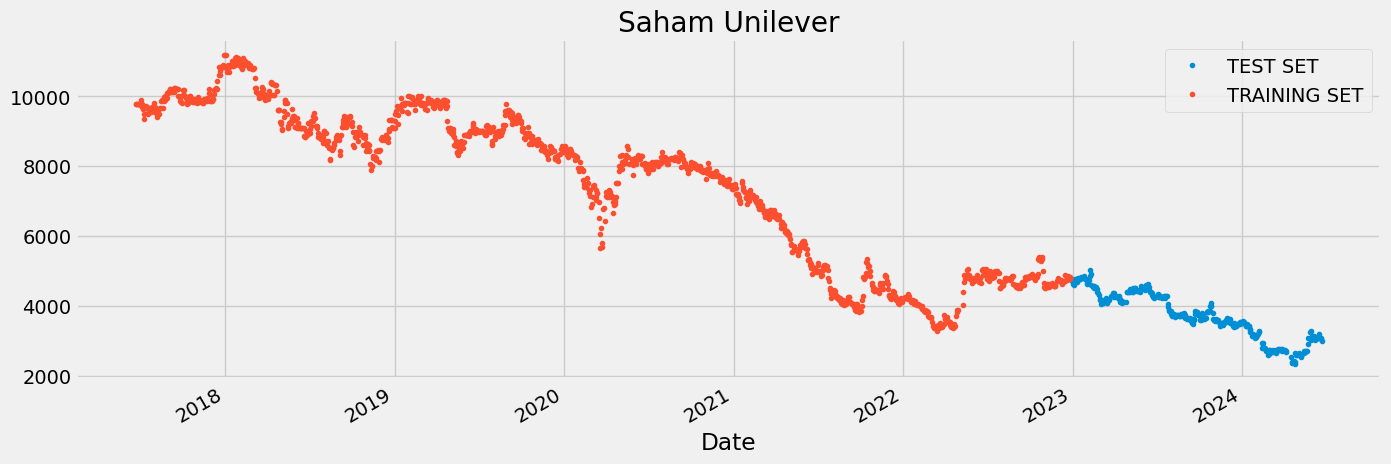

In [ ]:
# Visualize the splitted data on a plot
test.rename(columns={'Saham Unilever': 'TEST SET'}).join(train.rename(columns={'Saham Unilever': 'TRAINING SET'}), how='outer') \
.plot(figsize=(15,5), title='Saham Unilever', style='.')

In [ ]:
# Extract the features of the time series data
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(train, label='Saham Unilever')
X_test, y_test = create_features(test, label='Saham Unilever')

In [ ]:
#Training the XGB model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

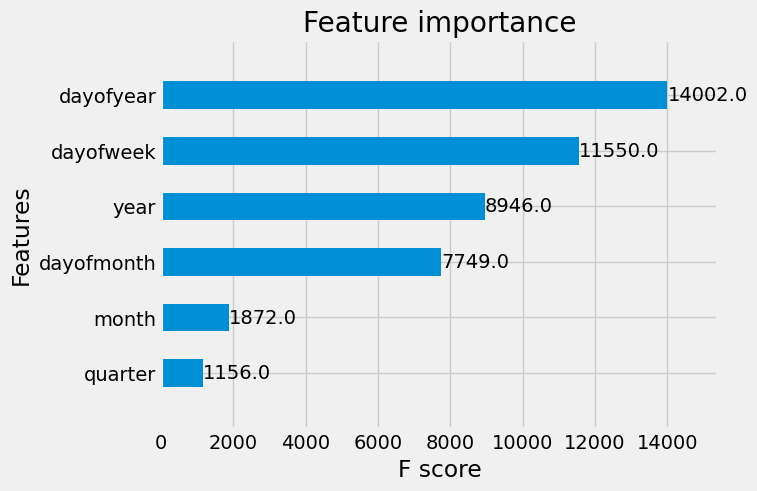

In [ ]:
plot_importance(reg, height=0.5)

In [ ]:
#Predict Unilever price for the test dataset and add the result to a new column in the test dataset
test['Saham Unilever_Predictions'] = reg.predict(X_test)
predictions = pd.concat([test, train], sort=False)
predictions.head()

,Saham Unilever,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,Saham Unilever_Predictions
Date,,,,,,,,,
2022-12-28,4770.0,2022-12-28,2,4,12,2022,362,28,4832.221191
2022-12-29,4760.0,2022-12-29,3,4,12,2022,363,29,4869.774902
2022-12-30,4700.0,2022-12-30,4,4,12,2022,364,30,4829.370117
2023-01-02,4620.0,2023-01-02,0,1,1,2023,2,2,4211.064941
2023-01-03,4600.0,2023-01-03,1,1,1,2023,3,3,4257.952637


<Axes: xlabel='Date'>

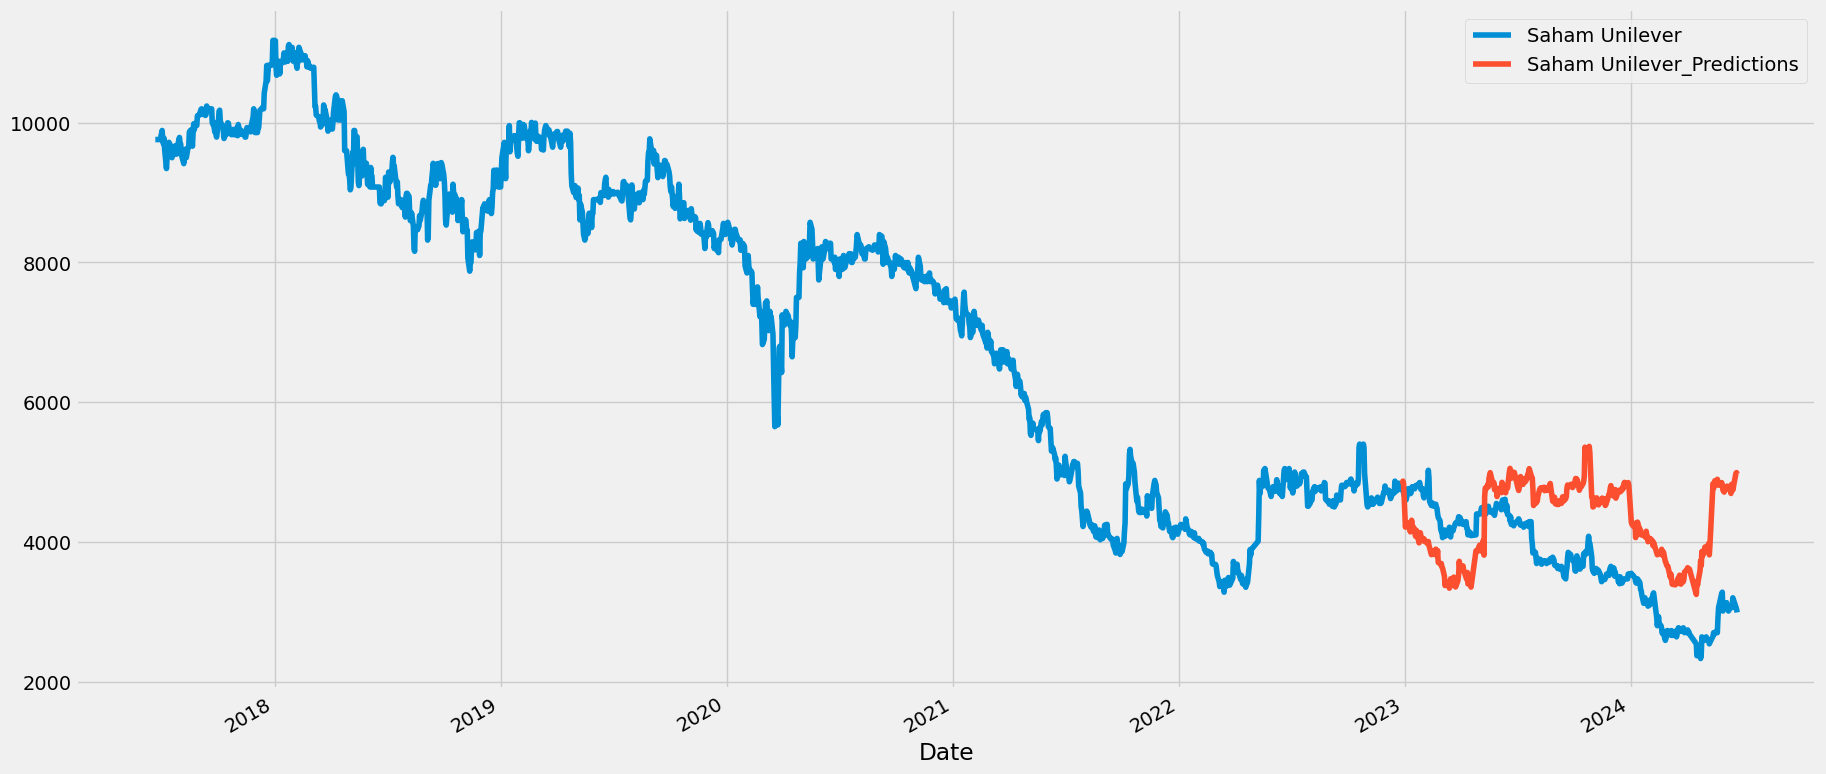

In [ ]:
#Plot the original time series data together with the predictions
predictions[['Saham Unilever','Saham Unilever_Predictions']].plot(figsize=(20, 10))

In [ ]:
# Calculating the error metrics RMSE, MAE, MAPE

print("MSE = ", mean_squared_error(y_true=test['Saham Unilever'], y_pred=test['Saham Unilever_Predictions']))
print("RMSE = ", mean_squared_error(y_true=test['Saham Unilever'],y_pred=test['Saham Unilever_Predictions']))
print("MAE = " , mean_absolute_error(y_true=test['Saham Unilever'],y_pred=test['Saham Unilever_Predictions']))
print("MAPE = ", mean_absolute_percentage_error(y_true=test['Saham Unilever'],y_pred=test['Saham Unilever_Predictions']))

MSE =  975059.1598925944
RMSE =  975059.1598925944
MAE =  907.2079304192183
MAPE =  0.2645442489796523


XGBoost (Prediction)

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

# The date range to be forecast
start_date = datetime(2024, 6, 22)
end_date = datetime(2024, 7, 6)

# Create a list of dates with one-day intervals using pandas.date_range
date_forecast = pd.date_range(start=start_date, end=end_date, freq='D')

In [ ]:
# Creating a DataFrame from a date range
df_forecast = pd.DataFrame({'Date': date_forecast})

# Create a function to create features from dates
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['Date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth']]
    return X

# Creating a feature from a date range
X_test = create_features(df_forecast)


In [ ]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,5,2,6,2024,174,22
1,6,2,6,2024,175,23
2,0,2,6,2024,176,24
3,1,2,6,2024,177,25
4,2,2,6,2024,178,26
5,3,2,6,2024,179,27
6,4,2,6,2024,180,28
7,5,2,6,2024,181,29
8,6,2,6,2024,182,30
9,0,3,7,2024,183,1


In [ ]:
predictions = reg.predict(X_test)
predictions

array([4952.448 , 4973.5596, 5033.6816, 4972.816 , 4993.355 , 4979.333 ,
       4937.603 , 4759.9385, 4728.177 , 4711.9067, 4816.9336, 4757.555 ,
       4785.066 , 4814.716 , 4889.038 ], dtype=float32)

In [ ]:
df_forecast['Saham Unilever Predictions'] = predictions
df_forecast['Date'] = date_forecast

In [ ]:
df_forecast
df_forecast.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

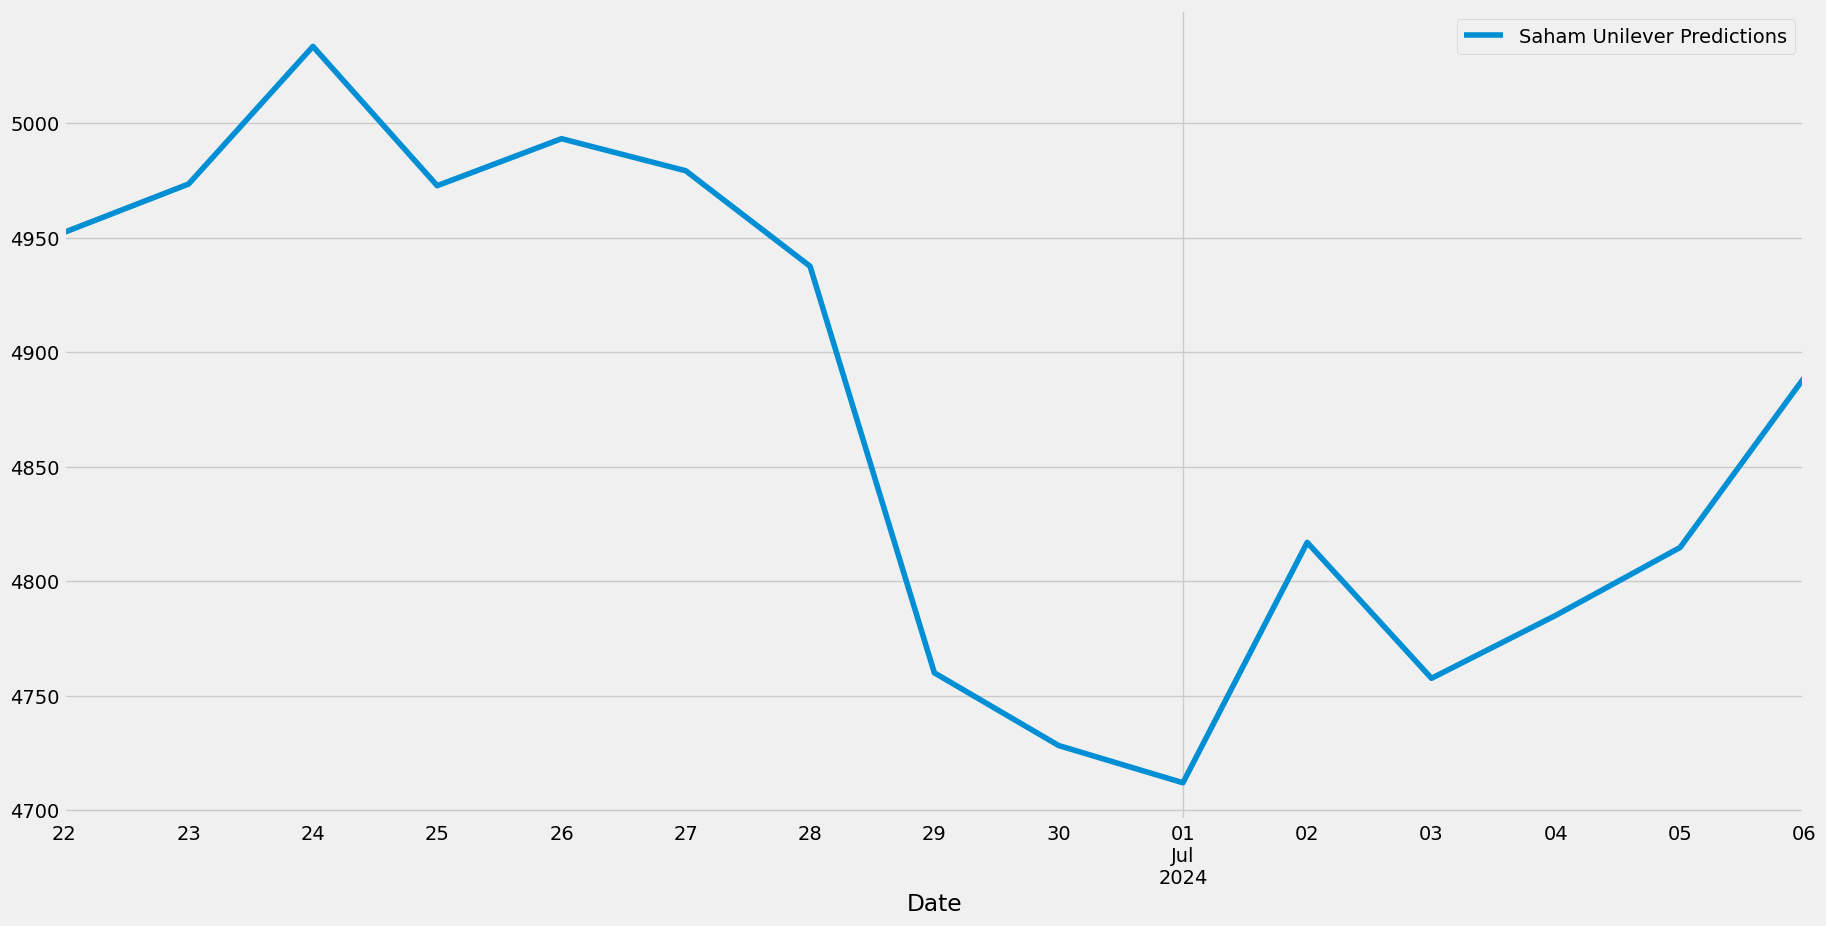

In [ ]:
#Plot the original time series data together with the predictions
df_forecast[['Saham Unilever Predictions']].plot(figsize=(20, 10))

In [ ]:
result_df = pd.concat([Data, df_forecast])
result_df

,Saham Unilever,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,Saham Unilever Predictions
Date,,,,,,,,,
2017-06-22,9760.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-23,9760.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-26,9760.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-27,9760.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-28,9760.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-07-02,4816.933594,2024-07-02,1.0,3.0,7.0,2024.0,184.0,2.0,4816.933594
2024-07-03,4757.555176,2024-07-03,2.0,3.0,7.0,2024.0,185.0,3.0,4757.555176
2024-07-04,4785.065918,2024-07-04,3.0,3.0,7.0,2024.0,186.0,4.0,4785.065918


<Axes: xlabel='Date'>

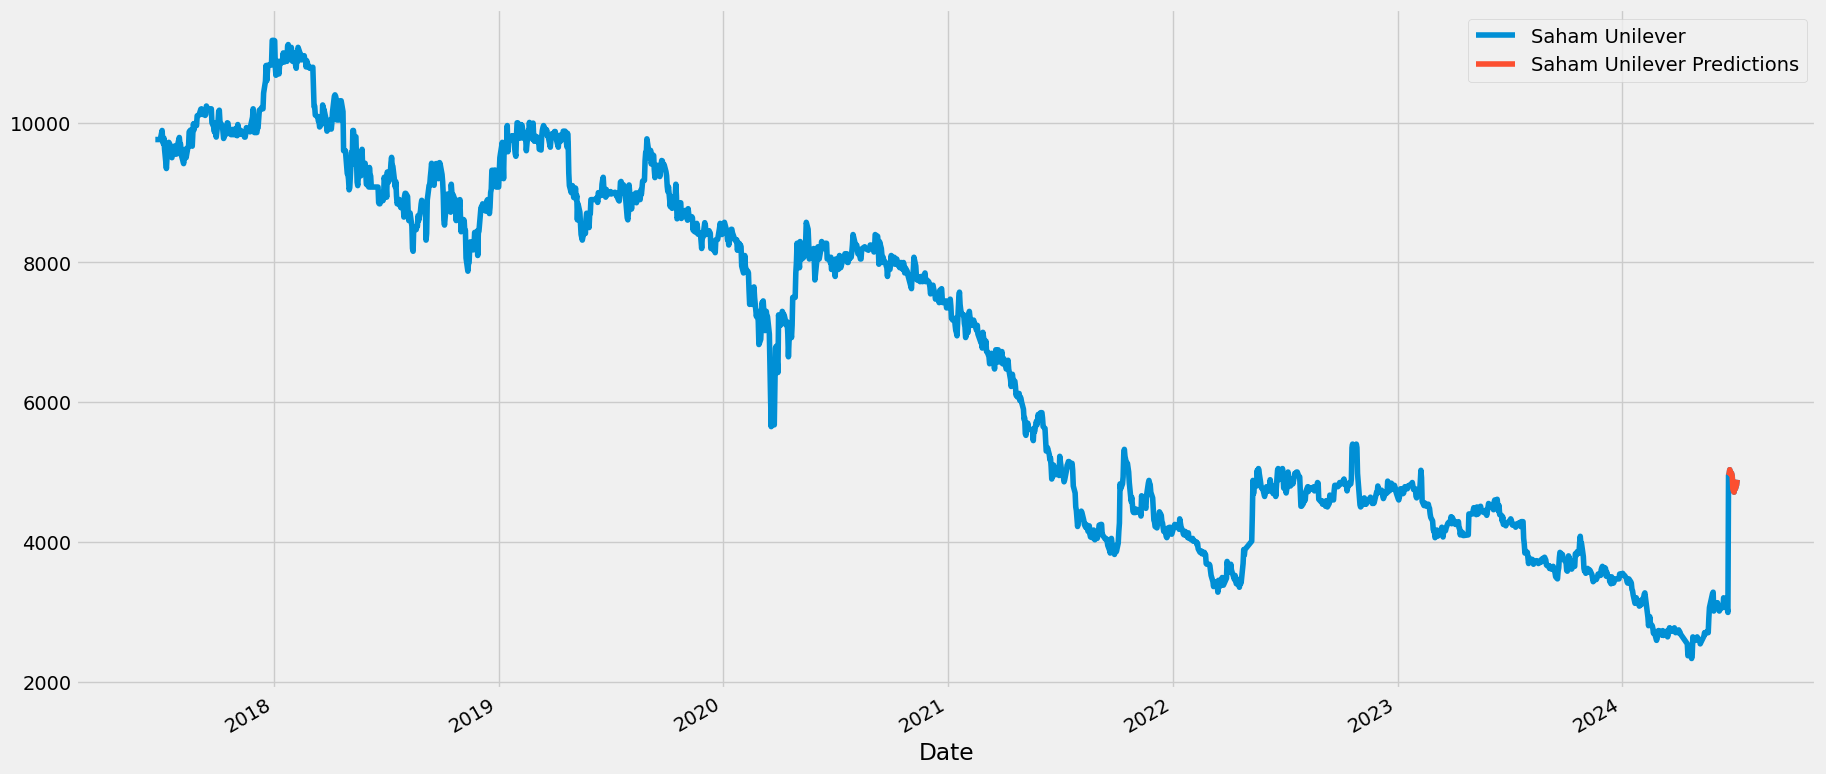

In [ ]:
#Plot the original time series data together with the predictions
result_df[['Saham Unilever','Saham Unilever Predictions']].plot(figsize=(20, 10))